In [167]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [151]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import pandas as pd
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras.models import load_model

OK_DIR = 'flaring(natural gas)/ok2'
NOTOK_DIR = 'flaring(natural gas)/notok2'
IMG_SIZE = 64


### Process input data

In [152]:
def create_data():
    original = []
    processed = []
    for img in tqdm(os.listdir(OK_DIR)):
        try:
            label = [0] #os.path.basename(OK_DIR)
            path = os.path.join(OK_DIR,img)
            img_ori = cv2.imread(path)
            #img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
            img_pro = cv2.imread(path)
            #img_pro = cv2.cvtColor(img_pro, cv2.COLOR_BGR2RGB)
            img_pro = cv2.resize(img_pro, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC)
            original.append([np.array(img_ori),np.array(label)])
            processed.append([np.array(img_pro),np.array(label)])
        except:
            pass
    for img in tqdm(os.listdir(NOTOK_DIR)):
        try:
            label = [1] #os.path.basename(NOTOK_DIR)
            path = os.path.join(NOTOK_DIR,img)
            img_ori = cv2.imread(path)
            #img_ori = cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB)
            img_pro = cv2.imread(path)
            #img_pro = cv2.cvtColor(img_pro, cv2.COLOR_BGR2RGB)
            img_pro = cv2.resize(img_pro, (IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC)
            original.append([np.array(img_ori),np.array(label)])
            processed.append([np.array(img_pro),np.array(label)])
        except:
            pass
    return original, processed

In [153]:
original, processed = create_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|██████████| 71/71 [00:00<00:00, 98.42it/s]


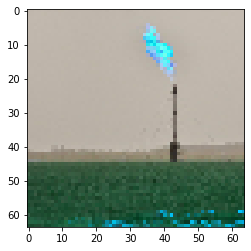

In [5]:
plt.imshow(np.asarray(processed)[3,0])

In [154]:
X = np.array([i[0] for i in processed])
Y = np.array([i[1] for i in processed])
X_ori = np.array([i[0] for i in original])
Y_ori = np.array([i[1] for i in original])

X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y,
                                                    test_size=0.2, random_state=42)
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(X_ori, Y_ori, stratify=Y_ori,
                                                    test_size=0.2, random_state=42)

X_test = X_test.reshape(X_test.shape[0],3,IMG_SIZE,IMG_SIZE)

Text(0.5, 0.98, 'Different Channels of Image: original, Red, Green Blue')

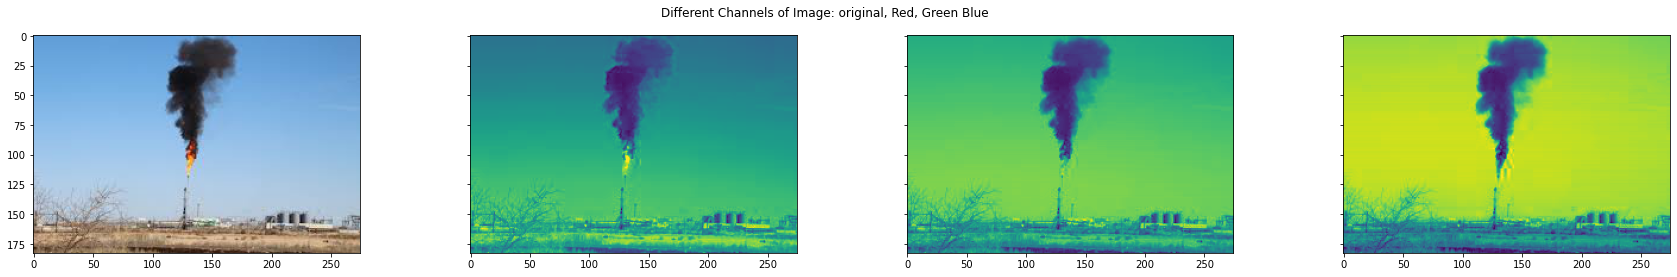

In [117]:
# plotting the original image and the RGB channels
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(30)
image= cv2.cvtColor(X_test_ori[9], cv2.COLOR_BGR2RGB)
ax1.imshow(image)

# RGB channels
# CHANNELID : 0 for Red, 1 for Green, 2 for Blue. 
ax2.imshow(image[:, : , 0]) #Red
ax3.imshow(image[:, : , 1]) #Green
ax4.imshow(image[:, : , 2]) #Blue
f.suptitle('Different Channels of Image: original, Red, Green Blue')

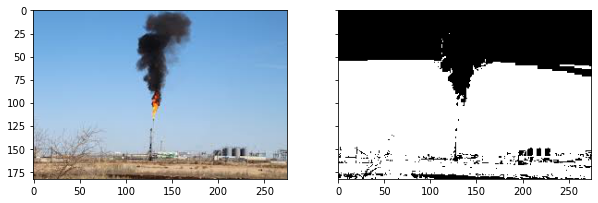

In [118]:
#The range of pixel varies between 0 to 255
#The pixel having black is more close to 0 and pixel which is white is more close to 255
# 125 is Arbitrary heuristic measure halfway between 1 and 255 (the range of image pixel) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
ax1.imshow(image)
bin_image = image[:, :, 0] > 125
ax2.imshow(bin_image, cmap='gray')

Text(0.5, 0.98, 'Preprocessing of Images: Binary image, Open Image, Close Image, Eroded Image, Dilated Image')

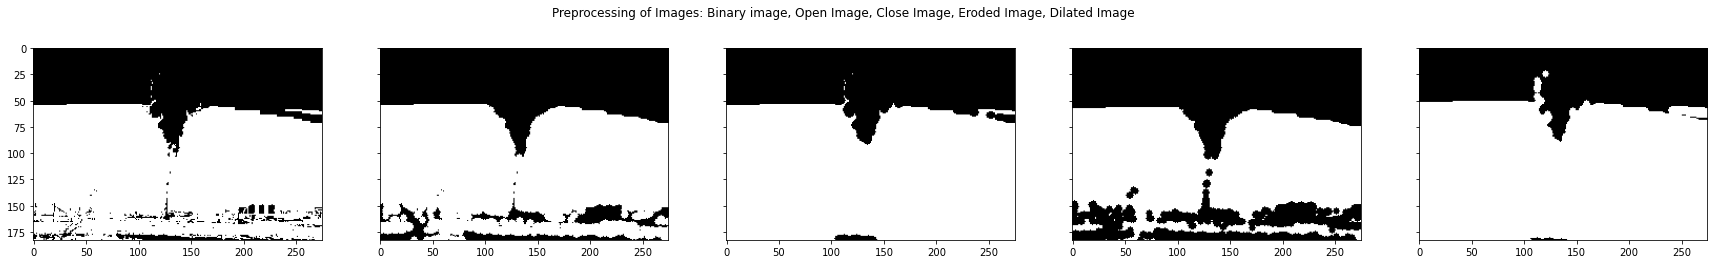

In [119]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import selem

# use a disk of radius 3
selem = selem.disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True)
f.set_figwidth(30)
ax1.imshow(bin_image, cmap='gray')
ax2.imshow(open_img, cmap='gray')
ax3.imshow(close_img, cmap='gray')
ax4.imshow(eroded_img, cmap='gray')
ax5.imshow(dilated_img, cmap='gray')
f.suptitle('Preprocessing of Images: Binary image, Open Image, Close Image, Eroded Image, Dilated Image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0.98, 'Normalization of Images: Original image, RGB, Medical/Non natural')

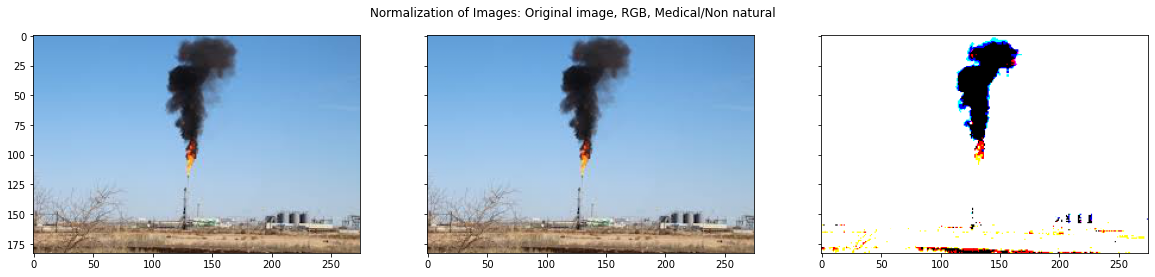

In [120]:
#way1-this is common technique followed in case of RGB images 
norm1_image = image/255
# #way2-in case of medical Images/non natural images 
# norm2_image = image - np.min(image)/np.max(image) - np.min(image)
#way3-in case of medical Images/non natural images 
norm3_image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figwidth(20)
ax1.imshow(image)
ax2.imshow(norm1_image)
ax3.imshow(norm3_image)
f.suptitle('Normalization of Images: Original image, RGB, Medical/Non natural')

Text(0.5, 0.98, 'Transformations of Images: Original image, Mirror flipping, Vertical flipping')

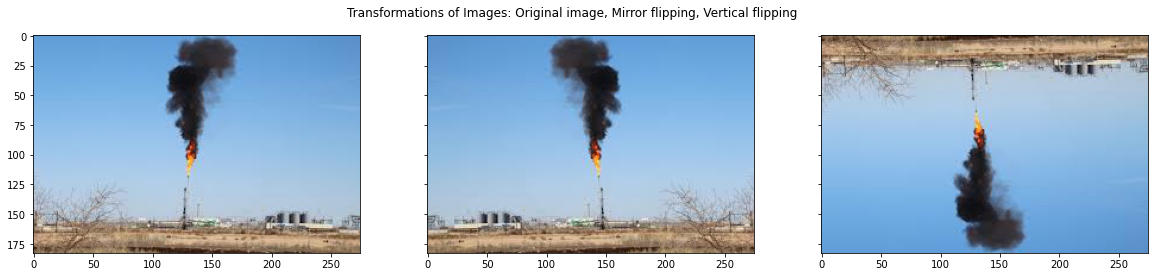

In [121]:
from skimage import transform as tf

# flip left-right, up-down
image_flipr = np.fliplr(image)
image_flipud = np.flipud(image)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
f.set_figwidth(20)

ax1.imshow(image)
ax2.imshow(image_flipr)
ax3.imshow(image_flipud)
f.suptitle('Transformations of Images: Original image, Mirror flipping, Vertical flipping')

Text(0.5, 0.98, 'Transformations of Images: Original image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_imag')

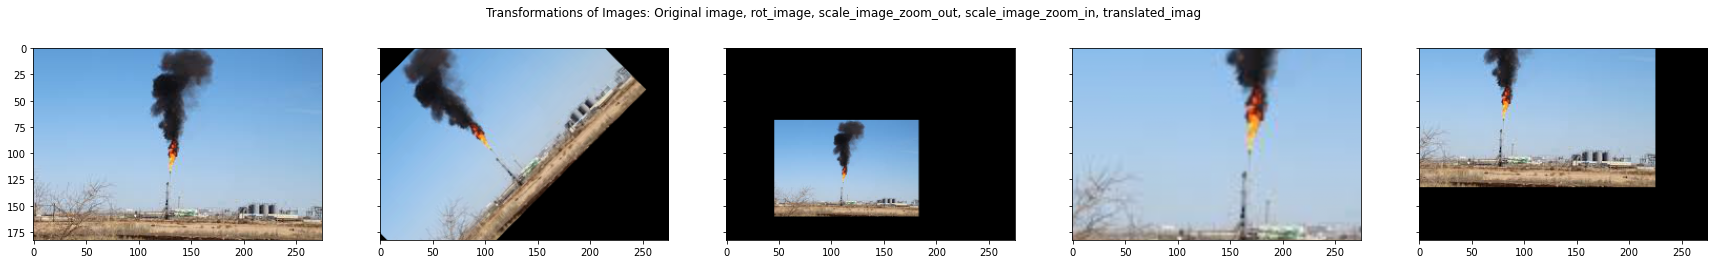

In [122]:
# specify x and y coordinates to be used for shifting (mid points)
shift_x, shift_y = image.shape[0]/2, image.shape[1]/2

# translation by certain units
matrix_to_topleft = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
matrix_to_center = tf.SimilarityTransform(translation=[shift_x, shift_y])

# rotation
rot_transforms =  tf.AffineTransform(rotation=np.deg2rad(45))
rot_matrix = matrix_to_topleft + rot_transforms + matrix_to_center
rot_image = tf.warp(image, rot_matrix)

# scaling 
scale_transforms = tf.AffineTransform(scale=(2, 2))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_out = tf.warp(image, scale_matrix)

scale_transforms = tf.AffineTransform(scale=(0.5, 0.5))
scale_matrix = matrix_to_topleft + scale_transforms + matrix_to_center
scale_image_zoom_in = tf.warp(image, scale_matrix)

# translation
transaltion_transforms = tf.AffineTransform(translation=(50, 50))
translated_image = tf.warp(image, transaltion_transforms)

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=True)
f.set_figwidth(30)

ax1.imshow(image)
ax2.imshow(rot_image)
ax3.imshow(scale_image_zoom_out)
ax4.imshow(scale_image_zoom_in)
ax5.imshow(translated_image)
f.suptitle('Transformations of Images: Original image, rot_image, scale_image_zoom_out, scale_image_zoom_in, translated_imag')

### Image Augmentation

In [159]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        data_format="channels_last")

x_aug=[]
y_aug=[]

for img in range(X_train.shape[0]):
    i = 0
    for x_batch, y_batch in datagen.flow(X_train[img].reshape((1,) + X_train[img].shape), y_train[img], batch_size=1,
                                        save_to_dir='preview', save_prefix='new_{}'.format(img), save_format='jpeg'):
        x_aug.append(x_batch)
        y_aug.append(y_batch)
        i += 1
        if i > 20:
            break  # otherwise the generator would loop indefinitely


In [161]:
x_aug = np.array(x_aug)
x_aug = x_aug.reshape(x_aug.shape[0], 3, IMG_SIZE, IMG_SIZE)

y_aug = np.array(y_aug)

### Convolutional Neural Network

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Flatten, MaxPooling2D, Dropout, Activation
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'

#create model
model = Sequential()

model.add(Convolution2D(32, 5, 5, padding='same', input_shape=(3, IMG_SIZE, IMG_SIZE), activation='relu'))
model.add(Convolution2D(32, 5, 5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
model.add(Convolution2D(64, 5, 5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
model.add(Convolution2D(128, 5, 5, padding='same', activation='relu'))
model.add(Convolution2D(128, 5, 5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
model.add(Convolution2D(256, 5, 5, padding='same', activation='relu'))
model.add(Convolution2D(256, 5, 5, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)



In [80]:
history = model.fit(x_aug, y_aug, validation_data=(X_test, y_test), epochs=4000, verbose=1, callbacks=[es, mc])

Epoch 1/4000
74/74 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5659
Epoch 00001: val_accuracy improved from -inf to 0.53571, saving model to models/best_model.h5
74/74 [==============================] - 9s 118ms/step - loss: 0.6908 - accuracy: 0.5659 - val_loss: 0.6829 - val_accuracy: 0.5357
Epoch 2/4000
74/74 [==============================] - ETA: 0s - loss: 0.6193 - accuracy: 0.6832
Epoch 00002: val_accuracy improved from 0.53571 to 0.64286, saving model to models/best_model.h5
74/74 [==============================] - 9s 117ms/step - loss: 0.6193 - accuracy: 0.6832 - val_loss: 0.6657 - val_accuracy: 0.6429
Epoch 3/4000
74/74 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.7164
Epoch 00003: val_accuracy did not improve from 0.64286
74/74 [==============================] - 9s 117ms/step - loss: 0.5556 - accuracy: 0.7164 - val_loss: 0.5940 - val_accuracy: 0.6429
Epoch 4/4000
74/74 [==============================] - ETA: 0s - loss: 0.5

Epoch 58/4000
74/74 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9864
Epoch 00058: val_accuracy did not improve from 0.89286
74/74 [==============================] - 10s 136ms/step - loss: 0.0470 - accuracy: 0.9864 - val_loss: 0.4663 - val_accuracy: 0.8214
Epoch 59/4000
74/74 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9881
Epoch 00059: val_accuracy improved from 0.89286 to 0.92857, saving model to models/best_model.h5
74/74 [==============================] - 11s 143ms/step - loss: 0.0341 - accuracy: 0.9881 - val_loss: 0.4336 - val_accuracy: 0.9286
Epoch 60/4000
74/74 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9877
Epoch 00060: val_accuracy did not improve from 0.92857
74/74 [==============================] - 11s 142ms/step - loss: 0.0306 - accuracy: 0.9877 - val_loss: 0.7629 - val_accuracy: 0.8214
Epoch 61/4000
74/74 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9911
Epoch 000

Epoch 87/4000
74/74 [==============================] - ETA: 0s - loss: 0.0414 - accuracy: 0.9919
Epoch 00087: val_accuracy did not improve from 0.96429
74/74 [==============================] - 11s 149ms/step - loss: 0.0414 - accuracy: 0.9919 - val_loss: 0.5347 - val_accuracy: 0.8929
Epoch 88/4000
74/74 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.9911
Epoch 00088: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 134ms/step - loss: 0.0333 - accuracy: 0.9911 - val_loss: 0.6250 - val_accuracy: 0.8571
Epoch 89/4000
74/74 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9970
Epoch 00089: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 135ms/step - loss: 0.0068 - accuracy: 0.9970 - val_loss: 0.7544 - val_accuracy: 0.8214
Epoch 90/4000
74/74 [==============================] - ETA: 0s - loss: 0.0727 - accuracy: 0.9898
Epoch 00090: val_accuracy did not improve from 0.96

Epoch 116/4000
74/74 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9983
Epoch 00116: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 142ms/step - loss: 0.0031 - accuracy: 0.9983 - val_loss: 0.4141 - val_accuracy: 0.8929
Epoch 117/4000
74/74 [==============================] - ETA: 0s - loss: 0.0307 - accuracy: 0.9919
Epoch 00117: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 130ms/step - loss: 0.0307 - accuracy: 0.9919 - val_loss: 0.5296 - val_accuracy: 0.8214
Epoch 118/4000
74/74 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9953
Epoch 00118: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 137ms/step - loss: 0.0192 - accuracy: 0.9953 - val_loss: 0.1920 - val_accuracy: 0.9643
Epoch 119/4000
74/74 [==============================] - ETA: 0s - loss: 0.0331 - accuracy: 0.9877
Epoch 00119: val_accuracy did not improve from 

Epoch 145/4000
74/74 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9970
Epoch 00145: val_accuracy did not improve from 0.96429
74/74 [==============================] - 11s 142ms/step - loss: 0.0304 - accuracy: 0.9970 - val_loss: 2.0502 - val_accuracy: 0.7857
Epoch 146/4000
74/74 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9949
Epoch 00146: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 136ms/step - loss: 0.0135 - accuracy: 0.9949 - val_loss: 0.7134 - val_accuracy: 0.8571
Epoch 147/4000
74/74 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9983
Epoch 00147: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 135ms/step - loss: 0.0039 - accuracy: 0.9983 - val_loss: 0.8628 - val_accuracy: 0.8214
Epoch 148/4000
74/74 [==============================] - ETA: 0s - loss: 0.0611 - accuracy: 0.9936
Epoch 00148: val_accuracy did not improve from 

Epoch 174/4000
74/74 [==============================] - ETA: 0s - loss: 0.0214 - accuracy: 0.9919
Epoch 00174: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 141ms/step - loss: 0.0214 - accuracy: 0.9919 - val_loss: 1.1417 - val_accuracy: 0.7857
Epoch 175/4000
74/74 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9979
Epoch 00175: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 132ms/step - loss: 0.0043 - accuracy: 0.9979 - val_loss: 1.9600 - val_accuracy: 0.8214
Epoch 176/4000
74/74 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9945
Epoch 00176: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 136ms/step - loss: 0.0375 - accuracy: 0.9945 - val_loss: 3.9576 - val_accuracy: 0.8571
Epoch 177/4000
74/74 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9974
Epoch 00177: val_accuracy did not improve from 

Epoch 203/4000
74/74 [==============================] - ETA: 0s - loss: 2.7638e-06 - accuracy: 1.0000
Epoch 00203: val_accuracy did not improve from 0.96429
74/74 [==============================] - 11s 146ms/step - loss: 2.7638e-06 - accuracy: 1.0000 - val_loss: 0.8011 - val_accuracy: 0.8214
Epoch 204/4000
74/74 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9962
Epoch 00204: val_accuracy did not improve from 0.96429
74/74 [==============================] - 12s 160ms/step - loss: 0.0342 - accuracy: 0.9962 - val_loss: 2.6489 - val_accuracy: 0.8214
Epoch 205/4000
74/74 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9949
Epoch 00205: val_accuracy did not improve from 0.96429
74/74 [==============================] - 11s 149ms/step - loss: 0.0221 - accuracy: 0.9949 - val_loss: 3.1704 - val_accuracy: 0.7857
Epoch 206/4000
74/74 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9983
Epoch 00206: val_accuracy did not impro

Epoch 232/4000
74/74 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9991
Epoch 00232: val_accuracy did not improve from 0.96429
74/74 [==============================] - 12s 163ms/step - loss: 0.0027 - accuracy: 0.9991 - val_loss: 3.5378 - val_accuracy: 0.8214
Epoch 233/4000
74/74 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 0.9966
Epoch 00233: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 131ms/step - loss: 0.0375 - accuracy: 0.9966 - val_loss: 2.5384 - val_accuracy: 0.8214
Epoch 234/4000
74/74 [==============================] - ETA: 0s - loss: 3.8916e-05 - accuracy: 1.0000
Epoch 00234: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 142ms/step - loss: 3.8916e-05 - accuracy: 1.0000 - val_loss: 2.3270 - val_accuracy: 0.8214
Epoch 235/4000
74/74 [==============================] - ETA: 0s - loss: 0.0191 - accuracy: 0.9983
Epoch 00235: val_accuracy did not impro

Epoch 261/4000
74/74 [==============================] - ETA: 0s - loss: 0.0344 - accuracy: 0.9915
Epoch 00261: val_accuracy did not improve from 0.96429
74/74 [==============================] - 13s 173ms/step - loss: 0.0344 - accuracy: 0.9915 - val_loss: 0.5701 - val_accuracy: 0.8929
Epoch 262/4000
74/74 [==============================] - ETA: 0s - loss: 0.0166 - accuracy: 0.9970
Epoch 00262: val_accuracy did not improve from 0.96429
74/74 [==============================] - 12s 159ms/step - loss: 0.0166 - accuracy: 0.9970 - val_loss: 1.2028 - val_accuracy: 0.8214
Epoch 263/4000
74/74 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9974
Epoch 00263: val_accuracy did not improve from 0.96429
74/74 [==============================] - 10s 140ms/step - loss: 0.0122 - accuracy: 0.9974 - val_loss: 1.7898 - val_accuracy: 0.8571
Epoch 264/4000
74/74 [==============================] - ETA: 0s - loss: 0.0274 - accuracy: 0.9962
Epoch 00264: val_accuracy did not improve from 

NameError: name 'load_model' is not defined

In [91]:
# load the saved model
saved_model = load_model('models/best_model.h5')
# evaluate the model
_, train_acc = saved_model.evaluate(x_aug, y_aug, verbose=0)
_, test_acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.981, Test: 0.964


In [75]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 1, 13, 32)         51232     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 1, 3, 32)          25632     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 1, 2, 32)          0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 1, 1, 64)          51264     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 1, 1, 64)          102464    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 1, 1, 128)        

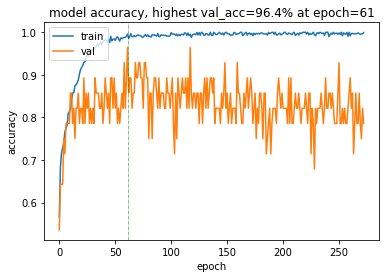

In [109]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy, highest val_acc=96.4% at epoch=61')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.axvline(x=61, color='g', linestyle='-.', lw=0.5)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

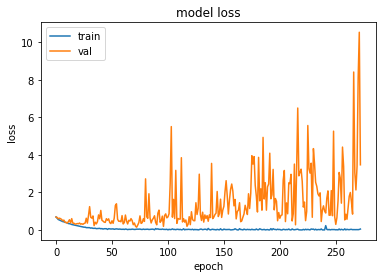

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Visually inspecting our network against unlabeled data #

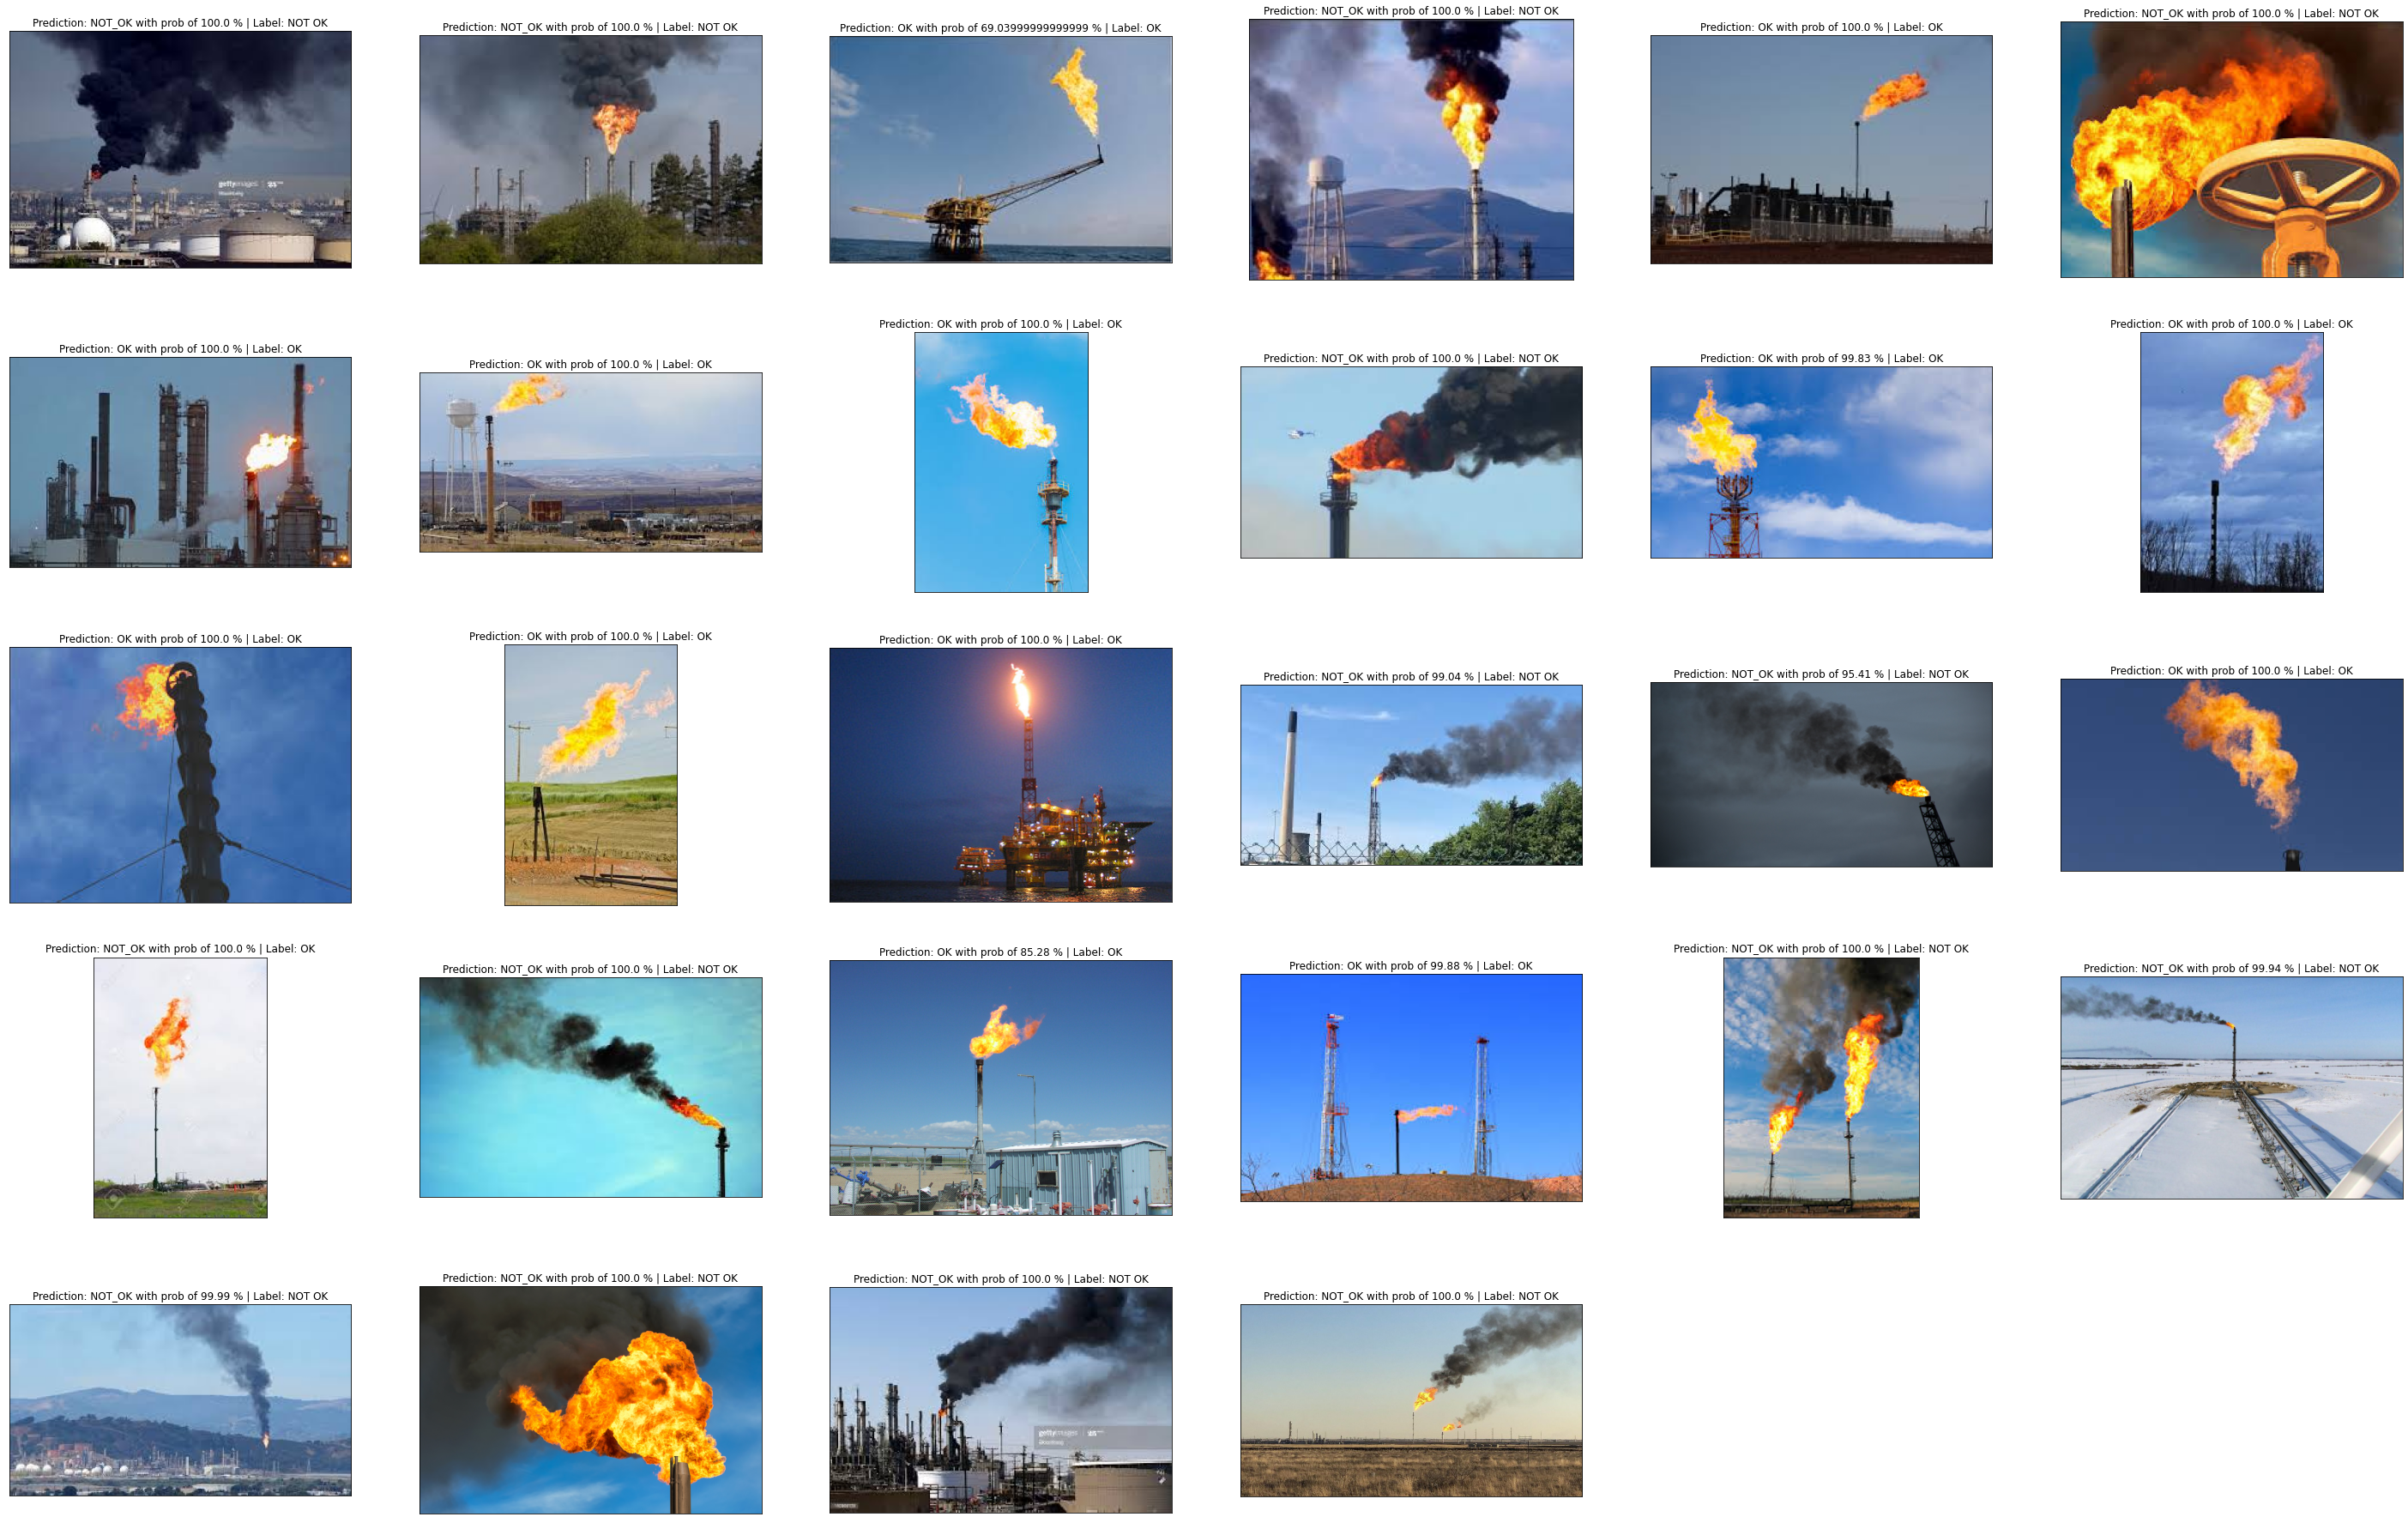

In [168]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize= (50,200))
for num,data in enumerate(X_test):
    
    y = fig.add_subplot(30,6,num+1)
    model_out = saved_model.predict(data.reshape(1, 3, IMG_SIZE,IMG_SIZE))

    if model_out >= 0.5:
        str_label='Prediction: NOT_OK with prob of ' + str(round(model_out[0,0] * 100,2)) + ' %'
    else: str_label='Prediction: OK with prob of ' + str(100 - (round(model_out[0,0] * 100,2))) + ' %'
        
    lab = y_test_ori[num]
    if (lab == [1]).all():
        true_label = ' | Label: NOT OK'
    else:
        true_label = ' | Label: OK'
        
    y.imshow(cv2.cvtColor(X_test_ori[num], cv2.COLOR_BGR2RGB))
    plt.title(str_label + true_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()